In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import xgboost, lightgbm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv
/kaggle/input/liverpool-ion-switching/train.csv


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')
print(train.shape, test.shape)

(5000000, 3) (2000000, 2)


In [4]:
train.head(10)

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0
5,0.0006,-2.6418,0
6,0.0007,-2.6993,0
7,0.0008,-2.5935,0
8,0.0009,-2.6682,0
9,0.0010,-2.7586,0


In [5]:
test.head(10)

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155
5,500.0006,-2.5659
6,500.0007,-2.7378
7,500.0008,-2.7788
8,500.0009,-2.8478
9,500.0010,-2.3758


In [6]:
train.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


# EDA


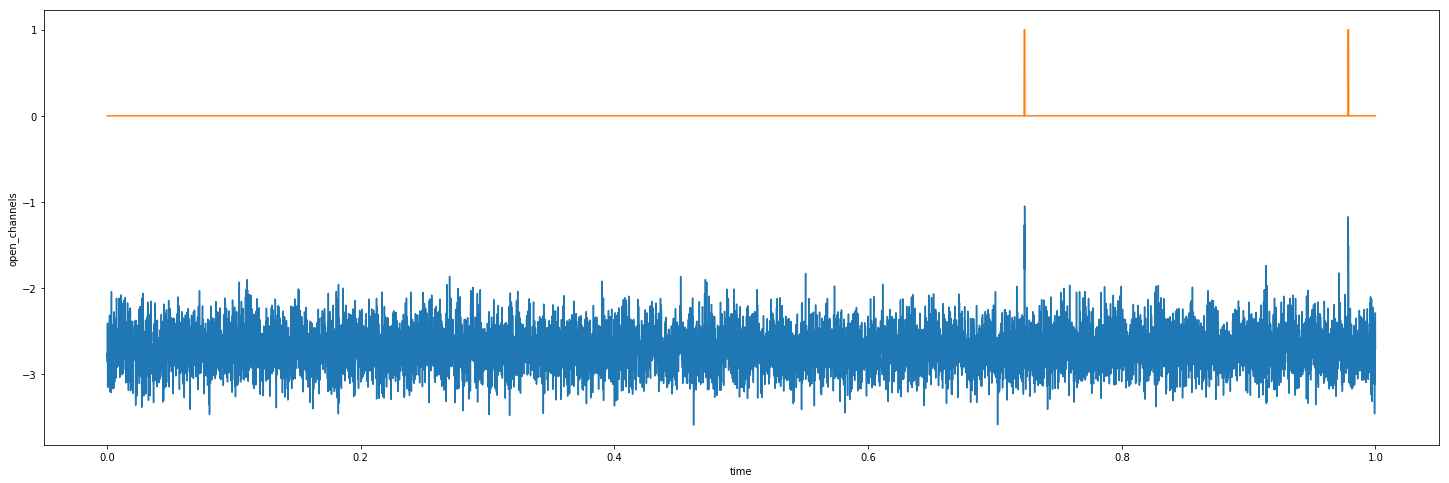

In [7]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[:10000], train.signal[:10000])
sns.lineplot(train.time[:10000], train.open_channels[:10000])

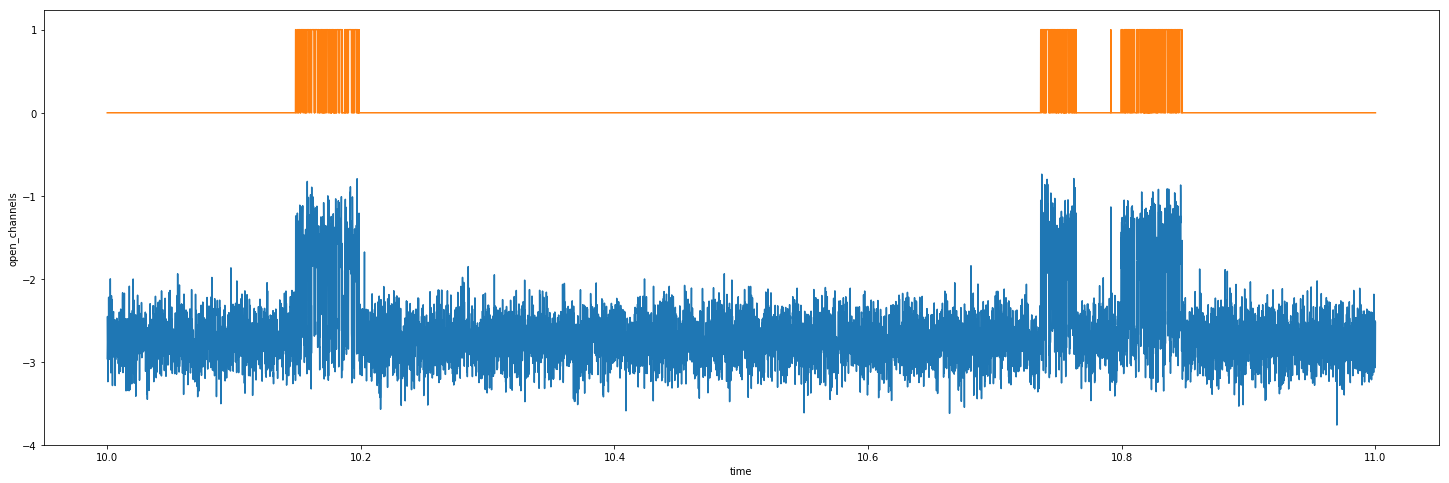

In [8]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[100000:110000], train.signal[100000:110000])
sns.lineplot(train.time[100000:110000], train.open_channels[100000:110000])

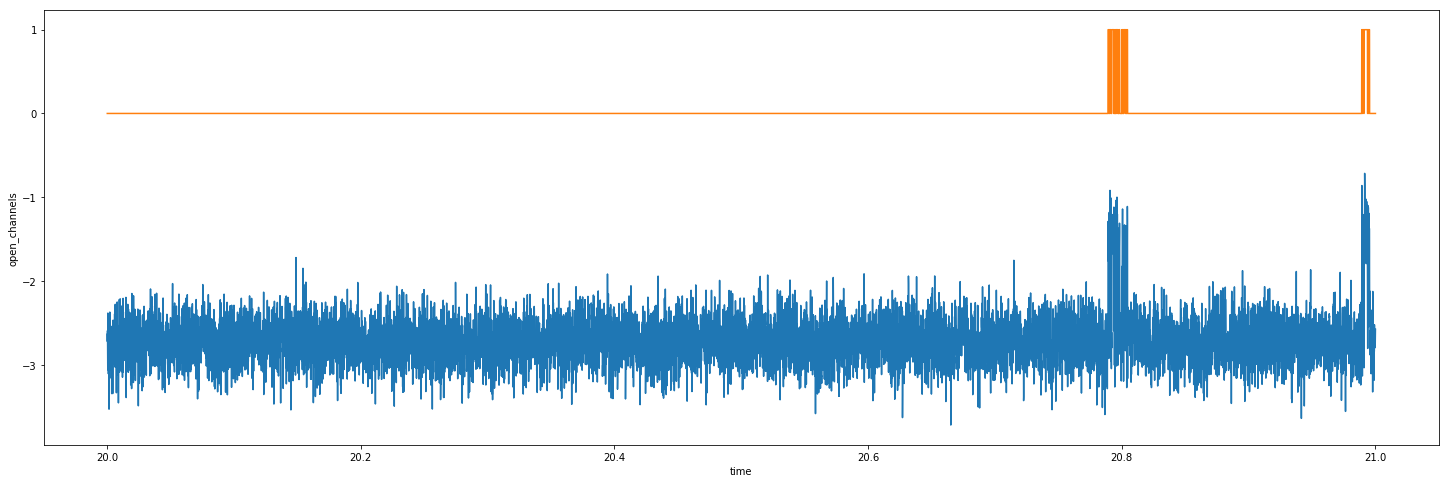

In [9]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[200000:210000], train.signal[200000:210000])
sns.lineplot(train.time[200000:210000], train.open_channels[200000:210000])

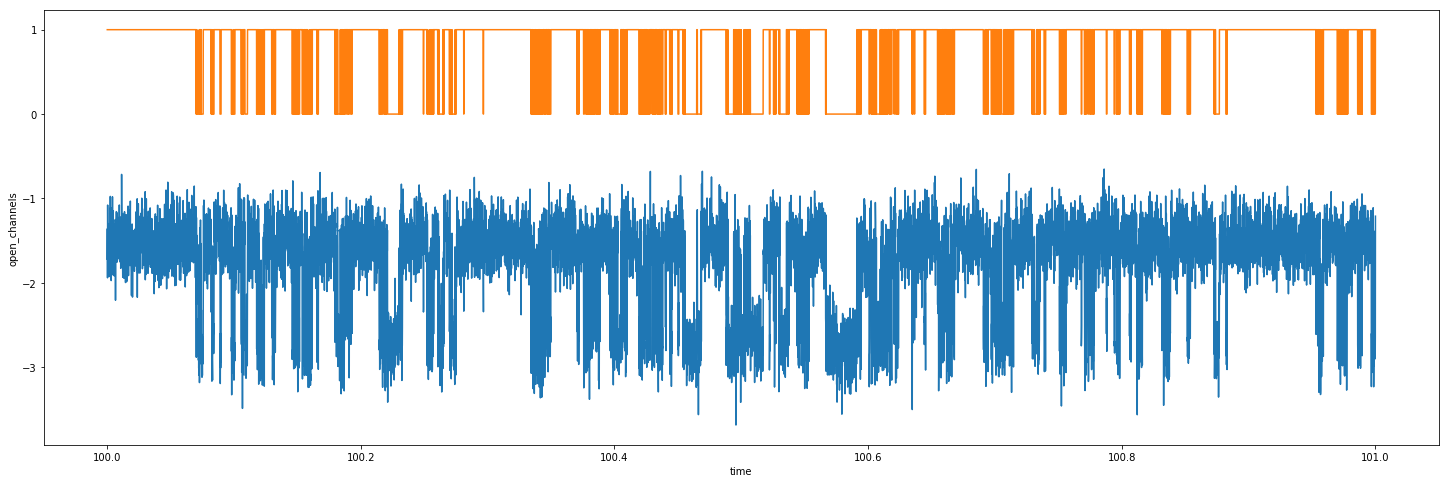

In [10]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[1000000:1010000], train.signal[1000000:1010000])
sns.lineplot(train.time[1000000:1010000], train.open_channels[1000000:1010000])

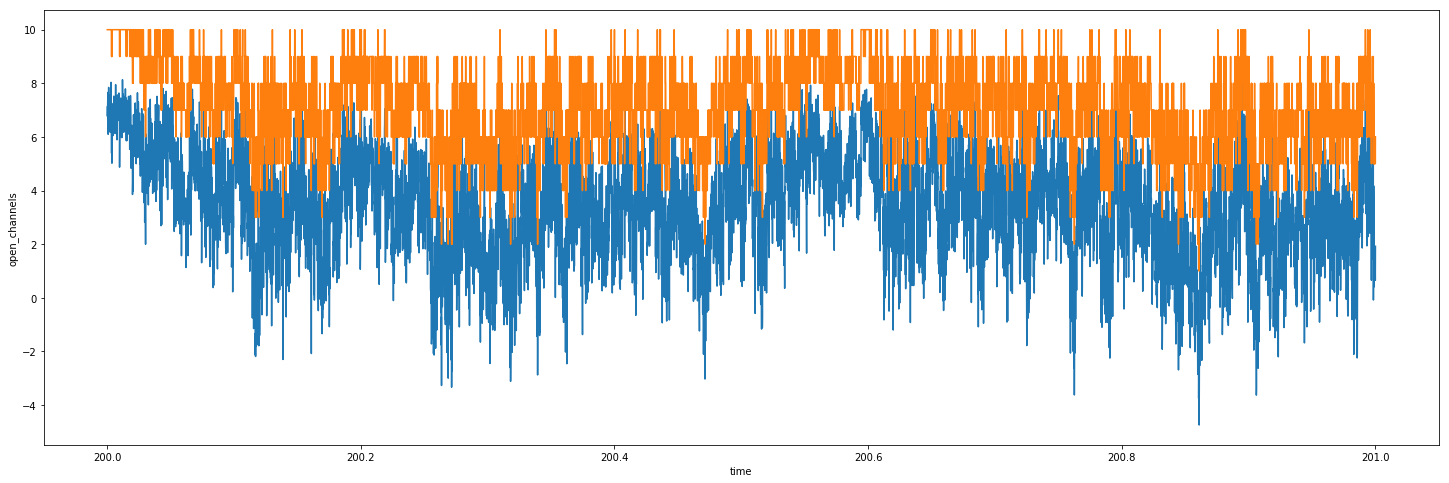

In [11]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[2000000:2010000], train.signal[2000000:2010000])
sns.lineplot(train.time[2000000:2010000], train.open_channels[2000000:2010000])

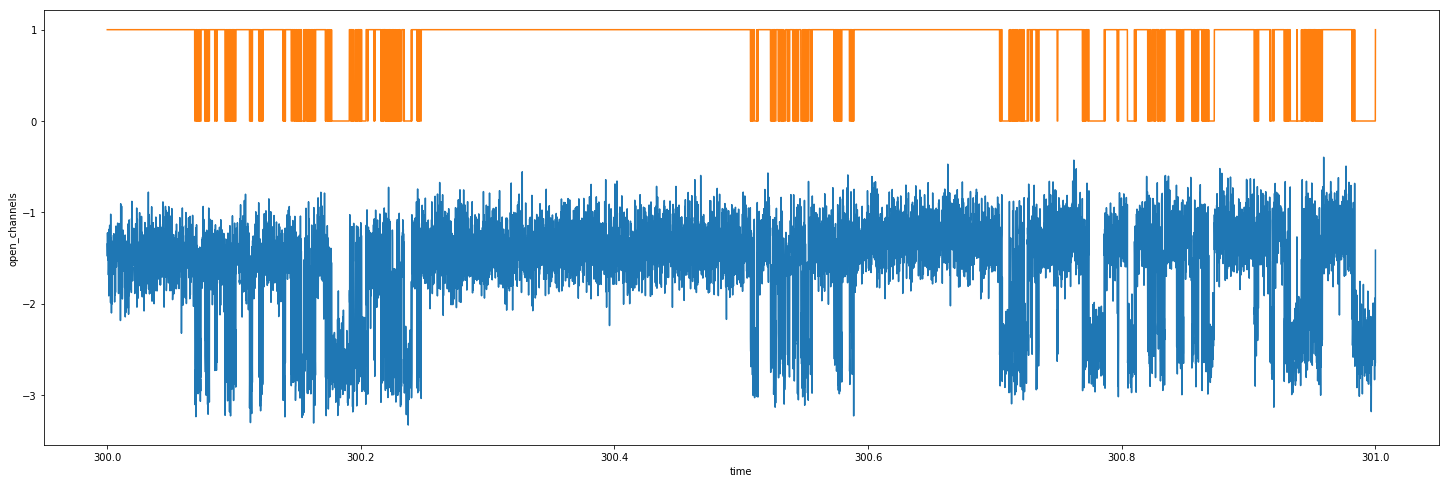

In [12]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[3000000:3010000], train.signal[3000000:3010000])
sns.lineplot(train.time[3000000:3010000], train.open_channels[3000000:3010000])

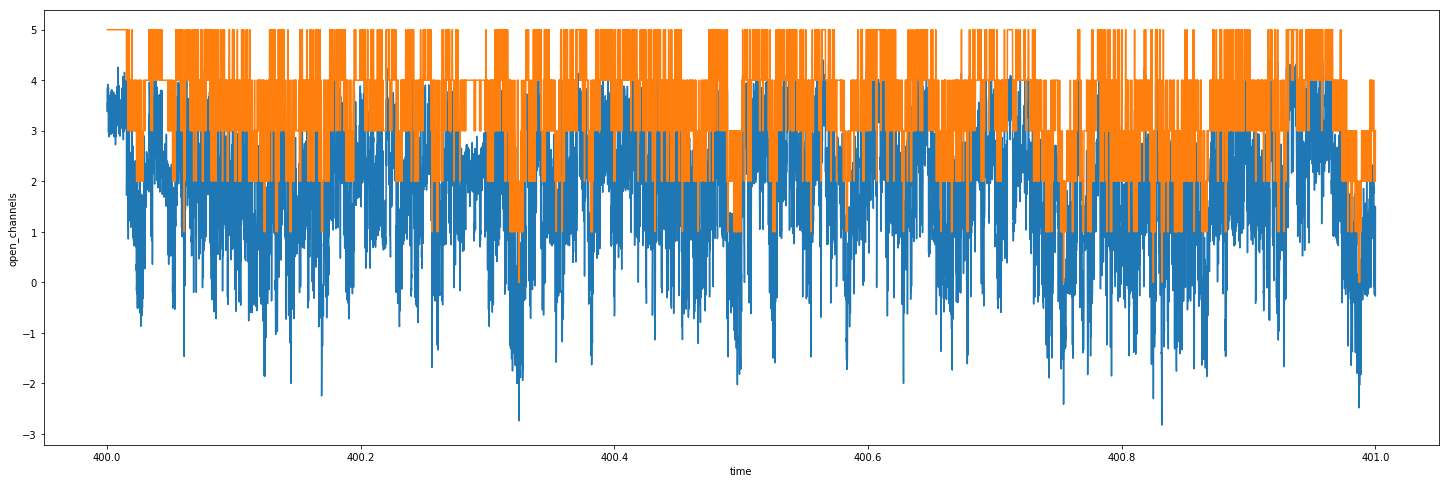

In [13]:
plt.figure(figsize=(25,8))
sns.lineplot(train.time[4000000:4010000], train.signal[4000000:4010000])
sns.lineplot(train.time[4000000:4010000], train.open_channels[4000000:4010000])

In [14]:
train.groupby('open_channels').mean()

,time,signal
open_channels,,
0,89.824994,-2.261752
1,231.211255,0.045153
2,291.448727,1.318063
3,308.694540,2.527458
4,349.830864,3.572789
5,350.406325,4.129024
6,351.473805,3.539624
7,350.157791,4.761342
8,349.574978,5.998460


# Feature Engineering

In [15]:
train['batch_time'] = test['batch_time'] = 0
for i in range(10):
    train['batch_time'][500000*i:500000*(1+i)] = train['time'][500000*i:500000*(1+i)] - 50*i
    
for i in range(3):
    test['batch_time'][500000*i:500000*(1+i)] = test['time'][500000*i:500000*(1+i)] - 50*(10+i)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
train['group'] = test['group'] = 0
for i in range(10):
    train['group'][500000*i:500000*(1+i)] = i
    
for i in range(3):
    test['group'][500000*i:500000*(1+i)] = i

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
train['signal_round_3'] = train['signal'].round(3)
train['signal_round_2'] = train['signal'].round(2)
train['signal_round_1'] = train['signal'].round(1)
train['signal_int'] = train['signal'].astype(int)
 
test['signal_round_3'] = test['signal'].round(3)
test['signal_round_2'] = test['signal'].round(2)
test['signal_round_1'] = test['signal'].round(1)
test['signal_int'] = test['signal'].astype(int)

train

,time,signal,open_channels,batch_time,group,signal_round_3,signal_round_2,signal_round_1,signal_int
0,0.0001,-2.7600,0,0.0001,0,-2.760,-2.76,-2.8,-2
1,0.0002,-2.8557,0,0.0002,0,-2.856,-2.86,-2.9,-2
2,0.0003,-2.4074,0,0.0003,0,-2.407,-2.41,-2.4,-2
3,0.0004,-3.1404,0,0.0004,0,-3.140,-3.14,-3.1,-3
4,0.0005,-3.1525,0,0.0005,0,-3.152,-3.15,-3.2,-3
...,...,...,...,...,...,...,...,...,...
4999995,499.9996,2.9194,7,49.9996,9,2.919,2.92,2.9,2
4999996,499.9997,2.6980,7,49.9997,9,2.698,2.70,2.7,2
4999997,499.9998,4.5164,8,49.9998,9,4.516,4.52,4.5,4
4999998,499.9999,5.6397,9,49.9999,9,5.640,5.64,5.6,5


In [ ]:
# train['bw-5and-6'] = train['signal'].apply(lambda x : 1 if x < -5 and x > -6 else 0)
# train['bw-4and-5'] = train['signal'].apply(lambda x : 1 if x < -4 and x > -5 else 0)
# train['bw-3and-4'] = train['signal'].apply(lambda x : 1 if x < -3 and x > -4 else 0)
# train['bw-2and-3'] = train['signal'].apply(lambda x : 1 if x < -2 and x > -3 else 0)
# train['bw-1and-2'] = train['signal'].apply(lambda x : 1 if x < -1 and x > -2 else 0)
# train['bw0and-1'] = train['signal'].apply(lambda x : 1 if x < 0 and x > -1 else 0)
# train['bw1and0'] = train['signal'].apply(lambda x : 1 if x < 1 and x > 0 else 0)
# train['bw2and1'] = train['signal'].apply(lambda x : 1 if x < 2 and x > 1 else 0)
# train['bw3and2'] = train['signal'].apply(lambda x : 1 if x < 3 and x > 2 else 0)
# train['bw4and3'] = train['signal'].apply(lambda x : 1 if x < 4 and x > 3 else 0)
# train['bw5and4'] = train['signal'].apply(lambda x : 1 if x < 5 and x > 4 else 0)
# train['bw6and5'] = train['signal'].apply(lambda x : 1 if x < 6 and x > 5 else 0)
# train['bw7and6'] = train['signal'].apply(lambda x : 1 if x < 7 and x > 6 else 0)
# train['bw8and7'] = train['signal'].apply(lambda x : 1 if x < 8 and x > 7 else 0)
# train['bw9and8'] = train['signal'].apply(lambda x : 1 if x < 9 and x > 8 else 0)
# train['bw10and9'] = train['signal'].apply(lambda x : 1 if x < 10 and x > 9 else 0)
# train['bw11and10'] = train['signal'].apply(lambda x : 1 if x < 11 and x > 10 else 0)
# train['bw12and11'] = train['signal'].apply(lambda x : 1 if x < 12 and x > 11 else 0)
# train['bw13and12'] = train['signal'].apply(lambda x : 1 if x < 13 and x > 12 else 0)
# train['bw14and13'] = train['signal'].apply(lambda x : 1 if x < 14 and x > 13 else 0)


# test['bw-5and-6'] = test['signal'].apply(lambda x : 1 if x < -5 and x > -6 else 0)
# test['bw-4and-5'] = test['signal'].apply(lambda x : 1 if x < -4 and x > -5 else 0)
# test['bw-3and-4'] = test['signal'].apply(lambda x : 1 if x < -3 and x > -4 else 0)
# test['bw-2and-3'] = test['signal'].apply(lambda x : 1 if x < -2 and x > -3 else 0)
# test['bw-1and-2'] = test['signal'].apply(lambda x : 1 if x < -1 and x > -2 else 0)
# test['bw0and-1'] = test['signal'].apply(lambda x : 1 if x < 0 and x > -1 else 0)
# test['bw1and0'] = test['signal'].apply(lambda x : 1 if x < 1 and x > 0 else 0)
# test['bw2and1'] = test['signal'].apply(lambda x : 1 if x < 2 and x > 1 else 0)
# test['bw3and2'] = test['signal'].apply(lambda x : 1 if x < 3 and x > 2 else 0)
# test['bw4and3'] = test['signal'].apply(lambda x : 1 if x < 4 and x > 3 else 0)
# test['bw5and4'] = test['signal'].apply(lambda x : 1 if x < 5 and x > 4 else 0)
# test['bw6and5'] = test['signal'].apply(lambda x : 1 if x < 6 and x > 5 else 0)
# test['bw7and6'] = test['signal'].apply(lambda x : 1 if x < 7 and x > 6 else 0)
# test['bw8and7'] = test['signal'].apply(lambda x : 1 if x < 8 and x > 7 else 0)
# test['bw9and8'] = test['signal'].apply(lambda x : 1 if x < 9 and x > 8 else 0)
# test['bw10and9'] = test['signal'].apply(lambda x : 1 if x < 10 and x > 9 else 0)
# test['bw11and10'] = test['signal'].apply(lambda x : 1 if x < 11 and x > 10 else 0)
# test['bw12and11'] = test['signal'].apply(lambda x : 1 if x < 12 and x > 11 else 0)
# test['bw13and12'] = test['signal'].apply(lambda x : 1 if x < 13 and x > 12 else 0)
# test['bw14and13'] = test['signal'].apply(lambda x : 1 if x < 14 and x > 13 else 0)

In [ ]:
# train['bw-4and-6'] = train['signal'].apply(lambda x : 1 if x < -4 and x > -6 else 0)
# train['bw-2and-4'] = train['signal'].apply(lambda x : 1 if x < -2 and x > -4 else 0)
# train['bw0and-2'] = train['signal'].apply(lambda x : 1 if x < 0 and x > -2 else 0)
# train['bw2and0'] = train['signal'].apply(lambda x : 1 if x < 2 and x > 0 else 0)
# train['bw4and2'] = train['signal'].apply(lambda x : 1 if x < 4 and x > 2 else 0)
# train['bw6and4'] = train['signal'].apply(lambda x : 1 if x < 6 and x > 4 else 0)
# train['bw8and6'] = train['signal'].apply(lambda x : 1 if x < 8 and x > 6 else 0)
# train['bw10and8'] = train['signal'].apply(lambda x : 1 if x < 10 and x > 8 else 0)
# train['bw12and10'] = train['signal'].apply(lambda x : 1 if x < 12 and x > 10 else 0)
# train['bw14and12'] = train['signal'].apply(lambda x : 1 if x < 14 and x > 12 else 0)

# test['bw-4and-6'] = test['signal'].apply(lambda x : 1 if x < -4 and x > -6 else 0)
# test['bw-2and-4'] = test['signal'].apply(lambda x : 1 if x < -2 and x > -4 else 0)
# test['bw0and-2'] = test['signal'].apply(lambda x : 1 if x < 0 and x > -2 else 0)
# test['bw2and0'] = test['signal'].apply(lambda x : 1 if x < 2 and x > 0 else 0)
# test['bw4and2'] = test['signal'].apply(lambda x : 1 if x < 4 and x > 2 else 0)
# test['bw6and4'] = test['signal'].apply(lambda x : 1 if x < 6 and x > 4 else 0)
# test['bw8and6'] = test['signal'].apply(lambda x : 1 if x < 8 and x > 6 else 0)
# test['bw10and8'] = test['signal'].apply(lambda x : 1 if x < 10 and x > 8 else 0)
# test['bw12and10'] = test['signal'].apply(lambda x : 1 if x < 12 and x > 10 else 0)
# test['bw14and12'] = test['signal'].apply(lambda x : 1 if x < 14 and x > 12 else 0)

In [18]:
columns = train.drop(['time', 'open_channels', 'batch_time', 'group'],1).columns
columns

Index(['signal', 'group', 'signal_round_3', 'signal_round_2', 'signal_round_1',
       'signal_int'],
      dtype='object')

In [19]:
for i in columns:
    train[f"{i}_mean"] = train.groupby('group')[i].transform('mean')
    train[f"{i}_median"] = train.groupby('group')[i].transform('median')
    train[f"{i}_min"] = train.groupby('group')[i].transform('min')
    train[f"{i}_max"] = train.groupby('group')[i].transform('max')
    train[f"{i}_sum"] = train.groupby('group')[i].transform('sum')
    
    test[f"{i}_mean"] = test.groupby('group')[i].transform('mean')
    test[f"{i}_median"] = test.groupby('group')[i].transform('median')
    test[f"{i}_min"] = test.groupby('group')[i].transform('min')
    test[f"{i}_max"] = test.groupby('group')[i].transform('max')
    test[f"{i}_sum"] = test.groupby('group')[i].transform('sum')

In [20]:
train

,time,signal,open_channels,batch_time,group,signal_round_3,signal_round_2,signal_round_1,signal_int,signal_mean,...,signal_round_1_mean,signal_round_1_median,signal_round_1_min,signal_round_1_max,signal_round_1_sum,signal_int_mean,signal_int_median,signal_int_min,signal_int_max,signal_int_sum
0,0.0001,-2.7600,0,0.0001,0,-2.760,-2.76,-2.8,-2,-2.681406,...,-2.681408,-2.7,-3.9,5.0,-1340704.0,-2.092292,-2,-3,4,-1046146
1,0.0002,-2.8557,0,0.0002,0,-2.856,-2.86,-2.9,-2,-2.681406,...,-2.681408,-2.7,-3.9,5.0,-1340704.0,-2.092292,-2,-3,4,-1046146
2,0.0003,-2.4074,0,0.0003,0,-2.407,-2.41,-2.4,-2,-2.681406,...,-2.681408,-2.7,-3.9,5.0,-1340704.0,-2.092292,-2,-3,4,-1046146
3,0.0004,-3.1404,0,0.0004,0,-3.140,-3.14,-3.1,-3,-2.681406,...,-2.681408,-2.7,-3.9,5.0,-1340704.0,-2.092292,-2,-3,4,-1046146
4,0.0005,-3.1525,0,0.0005,0,-3.152,-3.15,-3.2,-3,-2.681406,...,-2.681408,-2.7,-3.9,5.0,-1340704.0,-2.092292,-2,-3,4,-1046146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,499.9996,2.9194,7,49.9996,9,2.919,2.92,2.9,2,6.494006,...,6.494024,6.6,-3.9,13.2,3247011.9,5.998216,6,-3,13,2999108
4999996,499.9997,2.6980,7,49.9997,9,2.698,2.70,2.7,2,6.494006,...,6.494024,6.6,-3.9,13.2,3247011.9,5.998216,6,-3,13,2999108
4999997,499.9998,4.5164,8,49.9998,9,4.516,4.52,4.5,4,6.494006,...,6.494024,6.6,-3.9,13.2,3247011.9,5.998216,6,-3,13,2999108
4999998,499.9999,5.6397,9,49.9999,9,5.640,5.64,5.6,5,6.494006,...,6.494024,6.6,-3.9,13.2,3247011.9,5.998216,6,-3,13,2999108


In [21]:
test

,time,signal,batch_time,group,signal_round_3,signal_round_2,signal_round_1,signal_int,signal_mean,signal_median,...,signal_round_1_mean,signal_round_1_median,signal_round_1_min,signal_round_1_max,signal_round_1_sum,signal_int_mean,signal_int_median,signal_int_min,signal_int_max,signal_int_sum
0,500.0001,-2.6498,0.0001,0,-2.650,-2.65,-2.6,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
1,500.0002,-2.8494,0.0002,0,-2.849,-2.85,-2.8,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
2,500.0003,-2.8600,0.0003,0,-2.860,-2.86,-2.9,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
3,500.0004,-2.4350,0.0004,0,-2.435,-2.44,-2.4,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
4,500.0005,-2.6155,0.0005,0,-2.616,-2.62,-2.6,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,699.9996,-2.9092,0.0000,0,-2.909,-2.91,-2.9,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
1999996,699.9997,-2.7422,0.0000,0,-2.742,-2.74,-2.7,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
1999997,699.9998,-2.8285,0.0000,0,-2.828,-2.83,-2.8,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497
1999998,699.9999,-2.9092,0.0000,0,-2.909,-2.91,-2.9,-2,-1.392948,-2.4194,...,-1.392903,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497


In [22]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['time','open_channels', 'group'], 1), train['open_channels'], test_size=0.3, stratify=train['open_channels'])

Text(0.5, 1.0, 'val_set')

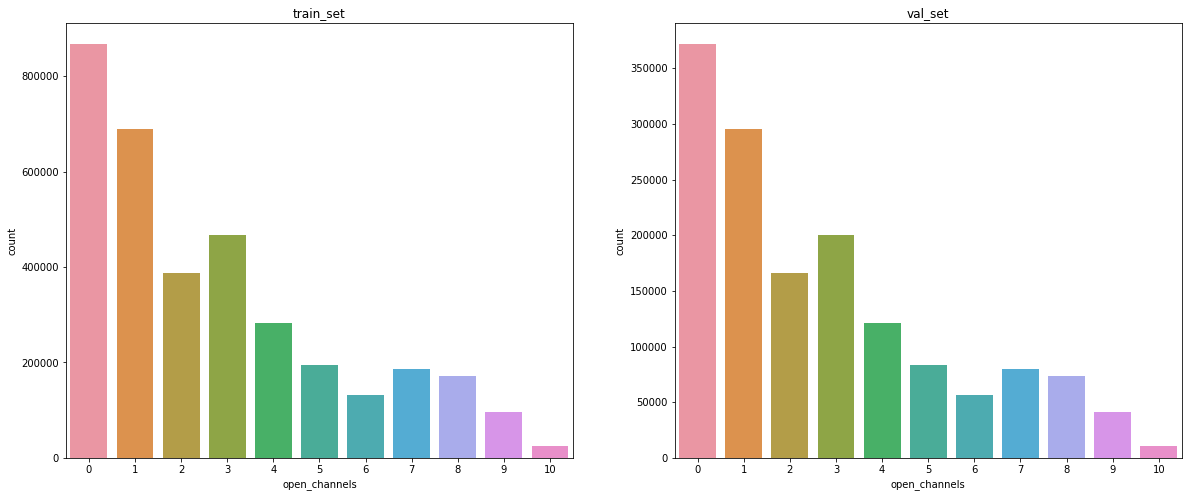

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot(y_train, ax=ax[0]).set_title('train_set')
sns.countplot(y_val, ax=ax[1]).set_title('val_set')

In [24]:
params = {
    'learning_rate' : 0.01,
    'n_estimators' : 100,
    'subsample':0.7,
    'verbosity': 1,
    'max_depth':10,
    'tree_method':'hist'
}

xgb = xgboost.XGBClassifier(**params)
xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.7,
              tree_method='hist', validate_parameters=False, verbosity=1)

In [25]:
%%time
xgb.fit(X_train, y_train)

CPU times: user 56min 17s, sys: 4.94 s, total: 56min 21s
Wall time: 15min 15s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='hist', validate_parameters=False, verbosity=1)

In [26]:
preds = xgb.predict(X_val)

Text(0.5, 1.0, 'Actual')

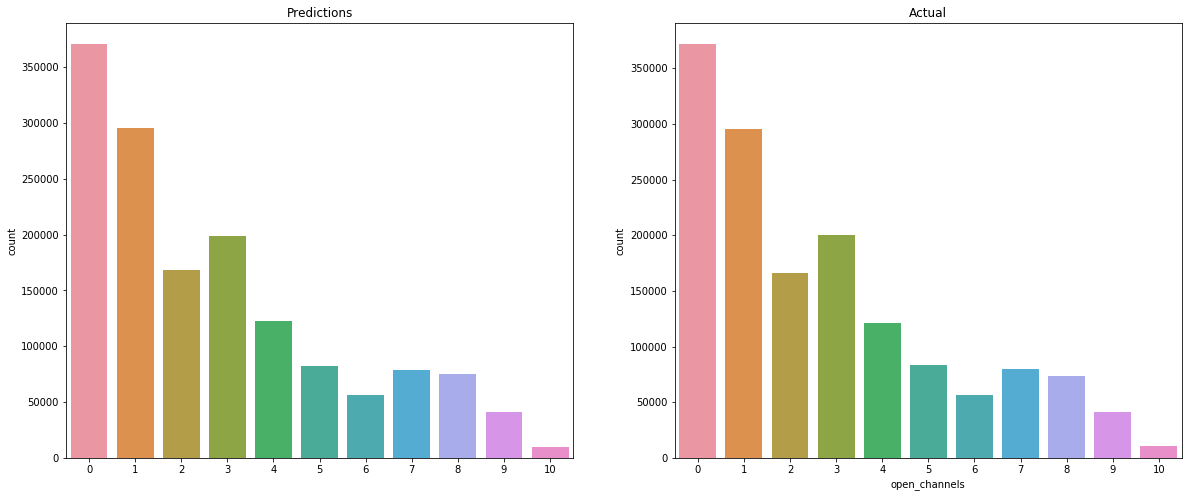

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot(preds, ax=ax[0]).set_title('Predictions')
sns.countplot(y_val, ax=ax[1]).set_title('Actual')

In [28]:
cm = confusion_matrix(preds, y_val).astype(int)

df_cm = pd.DataFrame(cm, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

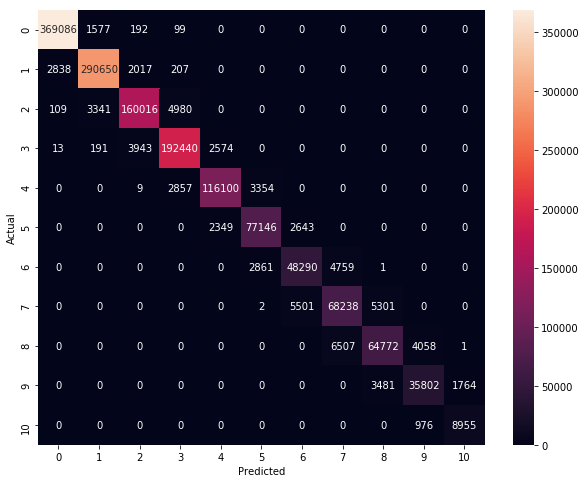

In [29]:
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size":10}, fmt='d')

In [30]:
print(f1_score(preds, y_val, average='macro'))

0.91947771078355


In [31]:
imp = pd.DataFrame()
imp['importance'] = xgb.feature_importances_
imp['column'] = X_train.columns
imp = imp.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
imp

,importance,column
0,0.371909,signal_max
1,0.270432,signal_mean
2,0.241299,signal_min
3,0.048135,signal_int
4,0.025886,group
5,0.015221,signal_round_1
6,0.010805,signal_round_2
7,0.009685,signal_round_3
8,0.005117,signal
9,0.001510,batch_time


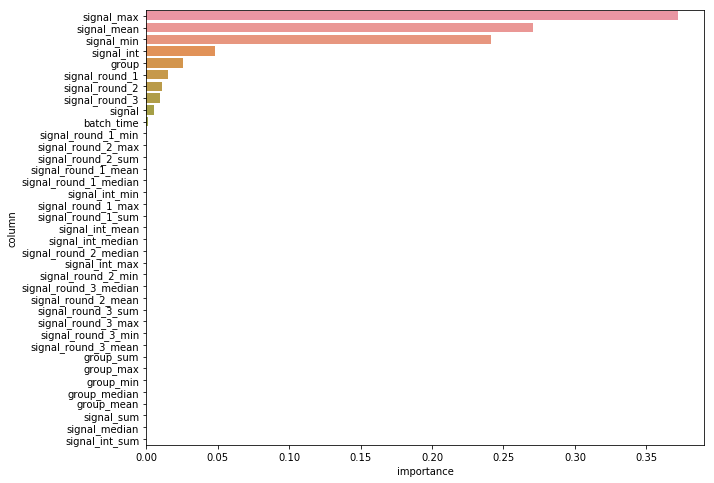

In [32]:
plt.figure(figsize=(10,8))
sns.barplot('importance', 'column', data=imp)

In [34]:
test_preds = xgb.predict(test.drop(['time', 'group'],1))
test_preds

array([0, 0, 0, ..., 0, 0, 0])

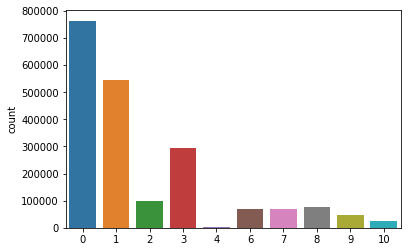

In [35]:
sns.countplot(test_preds)

In [36]:
test['open_channels'] = test_preds
test

,time,signal,batch_time,group,signal_round_3,signal_round_2,signal_round_1,signal_int,signal_mean,signal_median,...,signal_round_1_median,signal_round_1_min,signal_round_1_max,signal_round_1_sum,signal_int_mean,signal_int_median,signal_int_min,signal_int_max,signal_int_sum,open_channels
0,500.0001,-2.6498,0.0001,0,-2.650,-2.65,-2.6,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
1,500.0002,-2.8494,0.0002,0,-2.849,-2.85,-2.8,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
2,500.0003,-2.8600,0.0003,0,-2.860,-2.86,-2.9,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
3,500.0004,-2.4350,0.0004,0,-2.435,-2.44,-2.4,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
4,500.0005,-2.6155,0.0005,0,-2.616,-2.62,-2.6,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,699.9996,-2.9092,0.0000,0,-2.909,-2.91,-2.9,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
1999996,699.9997,-2.7422,0.0000,0,-2.742,-2.74,-2.7,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
1999997,699.9998,-2.8285,0.0000,0,-2.828,-2.83,-2.8,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0
1999998,699.9999,-2.9092,0.0000,0,-2.909,-2.91,-2.9,-2,-1.392948,-2.4194,...,-2.4,-4.0,4.9,-1392903.1,-1.068497,-2,-3,4,-1068497,0


In [37]:
test[['time', 'open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')